# Workfile

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedKFold, RepeatedStratifiedKFold
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import utils.mining_data_tb as md
import utils.visualization_tb as vi
import utils.models_tb as mo


import warnings

warnings.filterwarnings("ignore")

## Loading and preprocessing data

In [2]:
#### Load data
data_path = "data/hospital_train.csv"
variables_path = "data/columns_meaning.csv"

df = md.load_data(data_path, variables_path)

#### Preprocessing of categorical variables, as saw in 0_analysis file
# Preprocessor object
preprocessor = md.preprocessor()

# Process dummies
df = preprocessor.dummies(df)

# Map to process ordinal variables
to_map = ["Admission Type registered by the Hospital", "Severity of the illness recorded at the time of admission", "Age of the patient", "Stay Days by the patient"]

# Process ordinal variables
df = preprocessor.ordinal_mapper(df, to_map)

# Let's fill the NaNs with the mode an we are ready to go
df.loc[:, "Condition of Bed in the Ward"] = df.loc[:, "Condition of Bed in the Ward"].fillna(df.loc[:, "Condition of Bed in the Ward"].mode()[0])
df.loc[:, "City Code for the patient"] = df.loc[:, "City Code for the patient"].fillna(df.loc[:, "City Code for the patient"].mode()[0])

## Scaling the data

As we have categorical and numerical variablles all together and with different scales, it makes sense to scale the data, at least for the linear models such as Logistic Regression and SVMs. This way we avoid the models to give more weight to some variables due to scale.

RandomForest though probably won't be affected by this.

In [3]:
seed = 42

# Scaler
st_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

# Independent variables
X = np.array(df.drop("Stay Days by the patient", axis = 1))
X_st_scaled = st_scaler.fit_transform(X)
X_mm_scaled = mm_scaler.fit_transform(X)

# Dependent variable
y = np.array(df["Stay Days by the patient"])

## Logistic Regression

Let's try Logistic Regression again using the different scalers

In [4]:
# To train/test the models, I'll make use of a "modeller" class that will take care
# of all the steps and return the main metrics

# Model
model = LogisticRegression(max_iter = 1000, n_jobs = -1)
# Object definition
modeller = mo.modeller(model)

# Data and parameters to pass in to the modeller object
# Train/test data
X_train, X_test, y_train, y_test = train_test_split(X_st_scaled, y, test_size = .2, random_state = seed)
# Cross validation
kfold = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1)
# Data features
features = list(df.columns)


# Now we load the data into the model
modeller.load_data(X_train, X_test, y_train, y_test, features, kfold)

# Finally, we train the model (only in the training set and using cross validation)
modeller.trainer(verb = 2)


-- Model 1 --
-------------------------
>train score: 0.38846875
>validation score: 0.3931875
--------------------------------------------------
Set structure:
Train structure: {1: 0.074453125, 2: 0.243984375, 3: 0.273953125, 4: 0.172875, 5: 0.037234375, 6: 0.10990625, 7: 0.00875, 8: 0.0330625, 9: 0.014703125, 10: 0.009046875, 11: 0.02203125}
Validation structure: {1: 0.0744375, 2: 0.244, 3: 0.274, 4: 0.172875, 5: 0.0371875, 6: 0.109875, 7: 0.00875, 8: 0.0330625, 9: 0.0146875, 10: 0.0090625, 11: 0.0220625}
###########################################################################

-- Model 2 --
-------------------------
>train score: 0.389625
>validation score: 0.3868125
--------------------------------------------------
Set structure:
Train structure: {1: 0.074453125, 2: 0.243984375, 3: 0.273953125, 4: 0.172875, 5: 0.037234375, 6: 0.10990625, 7: 0.00875, 8: 0.0330625, 9: 0.014703125, 10: 0.009046875, 11: 0.02203125}
Validation structure: {1: 0.0744375, 2: 0.244, 3: 0.274, 4: 0.17287

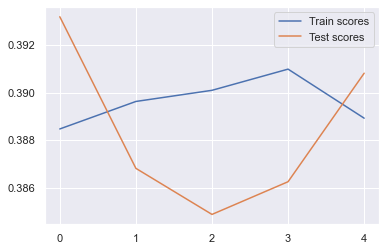

In [5]:
# Let's see the results
plt.plot(modeller.train_scores, label = "Train scores")
plt.plot(modeller.val_scores, label = "Test scores")
plt.legend()
plt.xticks(range(5))
plt.show()

In [6]:
modeller.tester(verb = 4)

-- Scores --
>Train score: 0.3896625
>Test score: 0.3906
--------------------------------------------------
--------------------------------------------------

-- Metrics --
Accuracy: None
Precision: 0.3906
Recall: 0.35688308494208715
F1 score: 0.3440637498045604
--------------------------------------------------

-- Confusion matrix --
[[  53  688  691   34    0    5    0    0    0    0    0]
 [  16 2271 2240  239    0  191    0    0    0    0    0]
 [   9 1605 3665  162    0   91    0    0    0    0    3]
 [   7  684 1460  656    0  659    0    0    0    0   15]
 [   5  157  419   52    0   53    0    0    0    0    4]
 [   3  205  349  612    0 1010    0    0    0    0   13]
 [   0   27   81   22    0   22    0    0    0    0    5]
 [   1   41   64  183    0  298    0    0    0    0   65]
 [   0   15   11   26    0  218    0    0    0    0   24]
 [   0   13   21   29    0   92    0    0    0    0   29]
 [   1   12   26   27    0  164    0    0    0    0  157]]
----------------------

Well, scaling the data really does help the model find the patterns and predict. In fact, now it isn't only predicting two categories, but up to 6!

Out of the two scalers, the StandardScaler() seems to be doing a bit of a better job.

Let's plot the relative confusion matrix to see clearer where the model is doing well or not.

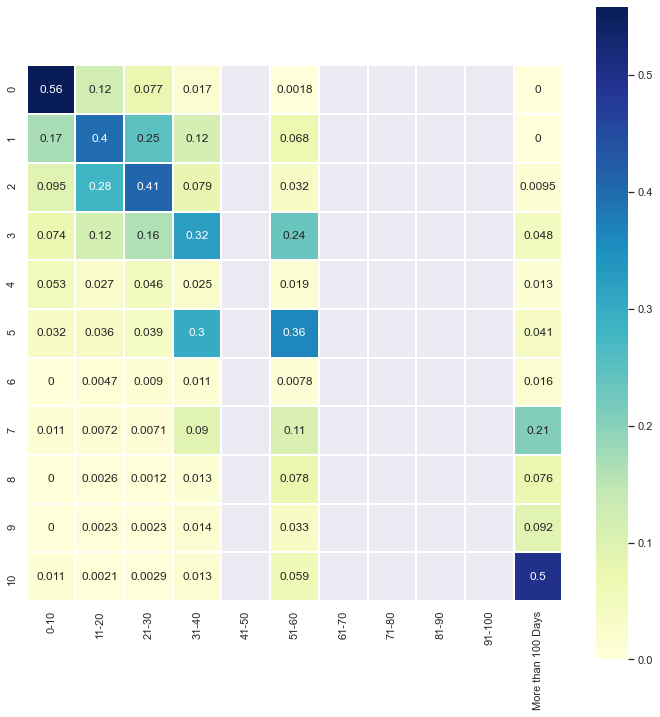

In [7]:
# To calculate the predicitons relative to the column sum
col_sum = modeller.cm.sum(axis = 0, keepdims = True)
col_rel = modeller.cm / col_sum

labels = preprocessor.target_variable()

# To plot
plt.figure(figsize = (12, 12))
sns.heatmap(col_rel, annot = True, linewidths = .1, square=True, cmap = "YlGnBu")

plt.xticks(np.arange(11) + .5, list(labels.values()), rotation = 90)

plt.show()

The model is doing fairly well compared to the based line. However, we can see that it is confusing quite a lot the categories "11-20" and "21-30".

It is also predicting many "51-60" as "31-40".

Let's try with other models now.

## More Machine Learning Models

Let's try several basic models at once and then check the metrics. Once I see which one performs best, I'll focus on some parameter tuning to try to bring the performance up.

In [8]:
# To test the models I will make use of an ensembler class that I created to
# test several models at once and save the relevant information of each of them

# 1) Models I want to test (basic versions)
model1 = RandomForestClassifier(n_jobs = -1, random_state = seed)
model2 = LogisticRegression(max_iter = 1000, n_jobs = -1, random_state = seed)
model3 = KNeighborsClassifier(n_neighbors = 3, n_jobs = -1)
model4 = SVC(max_iter = 200, random_state = seed)

# 2) Create the object passing in the models
ensembler = mo.ensembler([model1, model2, model3, model4])

# Load the data and train it with the full dataset
ensembler.load_data(X_train, X_test, y_train, y_test, features, kfold)
ensembler.tester(verb = 2)

Model RandomForestClassifier(n_jobs=-1, random_state=42) trained..
Model RandomForestClassifier(n_jobs=-1, random_state=42) scores calculated..
Model RandomForestClassifier(n_jobs=-1, random_state=42) metrics calculated..
Model RandomForestClassifier(n_jobs=-1, random_state=42) is ready
--------------------------------------------------
Model LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42) trained..
Model LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42) scores calculated..
Model LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42) metrics calculated..
Model LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42) is ready
--------------------------------------------------
Model KNeighborsClassifier(n_jobs=-1, n_neighbors=3) trained..
Model KNeighborsClassifier(n_jobs=-1, n_neighbors=3) scores calculated..
Model KNeighborsClassifier(n_jobs=-1, n_neighbors=3) metrics calculated..
Model KNeighborsClassifier(n_jobs=-1, n_neighbors=3) is ready
------

In [9]:
# Let's check the results
ensembler.metrics

,Test_score,Train_score,Test_score_drop,Accuracy,Precision,Recall,F1_score
"LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)",0.39060,0.389663,0.002406,NaN,0.39060,0.356883,0.344064
"RandomForestClassifier(n_jobs=-1, random_state=42)",0.38725,1.000000,-0.612750,NaN,0.38725,0.361451,0.360466
"KNeighborsClassifier(n_jobs=-1, n_neighbors=3)",0.29075,0.567825,-0.487958,NaN,0.29075,0.285700,0.276442
"SVC(max_iter=200, random_state=42)",0.15365,0.153900,-0.001624,NaN,0.15365,0.205388,0.114642


This list is sorted by "Test Score".

We can see that RandomForest is the one that performs the best using that metric, but it is awfully overfitting. We could correct this by limiting max_features for instance.

KNearestNeighbors is also overfitting. In this case, increasing the number of neighbors would definitely help, as the model would focus more on the trend than on specific cases and it would also be more robust to outliers. However, it is very slow in computing terms.

SVC performed very poorly, but that makes sense since I capped the model by max_iter, so I didn't give it the time to find the best solutions. This is also a very also model in computing terms though.

Let's try a bit more with RandomForest

## Random Forest Classifier

To test different combinations of this model, I will make use of a sklearn useful tool: RandomizedSearchCV

In [10]:
from sklearn.model_selection import RandomizedSearchCV

# Model
rf = RandomForestClassifier(n_jobs = -1, random_state = seed)

# Params to test
params = {"n_estimators" : [8, 16, 24, 32],
          "max_depth" : [5, 10, 15, 20],
          "max_features" : ["auto", "sqrt", "log2"]}

# Max number of combinations to randomly test
iterations = 12

# Defining RandomizedSearchCV object
random_search = RandomizedSearchCV(rf, param_distributions = params,
                                   n_iter = iterations, cv = 5)
# Training
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=12,
                   param_distributions={'max_depth': [5, 10, 15, 20],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [8, 16, 24, 32]})

In [11]:
# Let's see now that the best combination was and save it for further test
rf_end_model = random_search.best_estimator_
rf_end_model

RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=24,
                       n_jobs=-1, random_state=42)

In [12]:
# Now, let's make use of the modeller to train/test it with the full training
# set

modeller2 = mo.modeller(rf_end_model)

# Loading data
modeller2.load_data(X_train, X_test, y_train, y_test, features, kfold)

# Train with the full training set and test it with the test set
modeller2.tester(verb = 4)

-- Scores --
>Train score: 0.44265
>Test score: 0.40375
--------------------------------------------------
--------------------------------------------------

-- Metrics --
Accuracy: None
Precision: 0.40375
Recall: 0.37239642270868445
F1 score: 0.3560461342986153
--------------------------------------------------

-- Confusion matrix --
[[  65  733  664    4    0    5    0    0    0    0    0]
 [  23 2458 2116  187    0  173    0    0    0    0    0]
 [  12 1624 3753   54    0   92    0    0    0    0    0]
 [   6  647 1543  741    0  539    0    0    0    0    5]
 [   7  149  443   37    0   52    0    0    0    0    2]
 [   4  197  395  600    0  993    0    0    0    0    3]
 [   0   30   85   11    0   28    0    0    0    0    3]
 [   2   43   97  157    0  328    0    0    0    0   25]
 [   0   22   19   54    0  192    0    0    0    0    7]
 [   0   11   27   29    0  106    0    0    0    0   11]
 [   2   20   28   67    0  205    0    0    0    0   65]]
----------------------

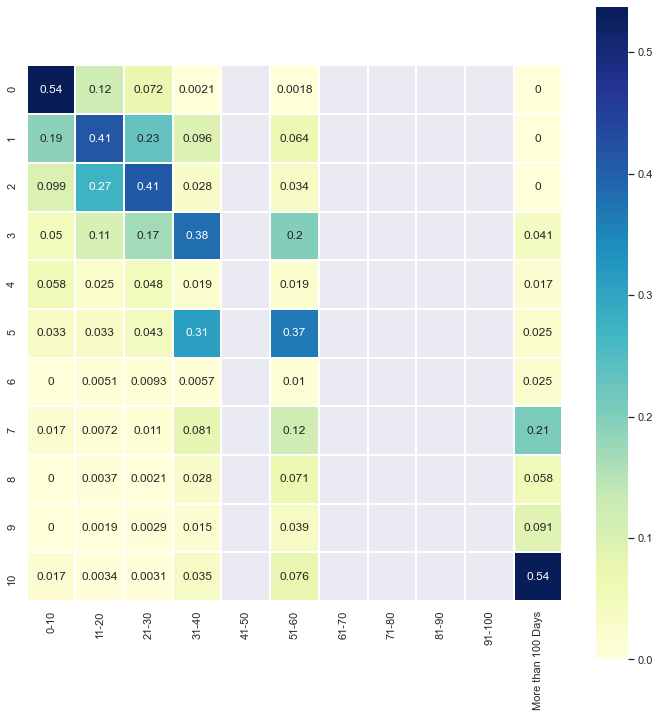

In [13]:
# Let's plot this
# To calculate the predicitons relative to the column sum
col_sum = modeller2.cm.sum(axis = 0, keepdims = True)
col_rel = modeller2.cm / col_sum

labels = preprocessor.target_variable()

# To plot
plt.figure(figsize = (12, 12))
sns.heatmap(col_rel, annot = True, linewidths = .1, square=True, cmap = "YlGnBu")

plt.xticks(np.arange(11) + .5, list(labels.values()), rotation = 90)

plt.show()

Even though the test score is a bit better than the one we got from the LogisticRegression model, this RandomForest model has a drop in performance when using the test data, whereas the LogisticRegression one actually improves. This means, LogisticRegression is generalizing better.

That said, they perform quite similarly. In fact, they are going for the same categories with their predictions.